In [4]:
# IMPORT & LOAD LIBRARY + DATA
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import lightgbm as lgb
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import LabelEncoder
pd.set_option('display.max_columns', None)  # Tampilkan semua kolom

# Load Data
train_df = pd.read_csv("train.csv")
test_df = pd.read_csv("test.csv")
sample_submission_df = pd.read_csv("submission.csv")
print("Data Berhasil Terload")

# Simpan ID test_df untuk submission
test_ids = test_df['ID'] 

# Menambahkan kolos is_test di masing masing data
train_df['is_test'] = 0
test_df['is_test'] = 1

# Rename Electricity Consumption di train_df
train_df.rename(columns={'electricity_consumption_gwh': 'electricity_consumption'}, inplace=True)

# MERGING & RAPIHIN DATA TRAIN DAN TEST 

# Menggabungkan train_df dan test_df
test_df['electricity_consumption'] = np.nan
all_df = pd.concat([train_df.drop(columns=['ID']), test_df.drop(columns=['ID'])], ignore_index=True)

# Menampilkan informasi DataFrame
print("\n--- Kombinasi dua data (5 Baris Pertama) ---")
print(all_df.head())
print("\n--- Info Kombinasi dua data ---")
print(all_df.info())

# Mengconvert kolom 'date' ke tipe datetime
all_df['date'] = pd.to_datetime(all_df['date'])

# Sort & Tampilkan data berdasarkan tahunnya 
all_df = all_df.sort_values(by=['cluster_id', 'date']).reset_index(drop=True)
print("\n--- Data setelah diurutkan ---")
print(all_df.head())

Data Berhasil Terload

--- Kombinasi dua data (5 Baris Pertama) ---
         date cluster_id  electricity_consumption  temperature_2m_max  \
0  2014-01-01  cluster_1                  358.032                10.8   
1  2014-01-01  cluster_2                  548.247                12.2   
2  2014-01-01  cluster_3                  758.303                12.9   
3  2014-01-01  cluster_4                 1072.077                10.8   
4  2014-01-02  cluster_1                  386.908                10.7   

   temperature_2m_min  apparent_temperature_max  apparent_temperature_min  \
0                 4.2                       5.5                       0.4   
1                 4.3                       8.6                      -0.4   
2                -0.8                      10.1                      -4.9   
3                 4.7                       6.7                       0.6   
4                 7.0                       6.6                       3.3   

   sunshine_duration  daylight

In [ ]:
train_df.head()

In [ ]:
# FEATURE ENGINEERING 

# --- Time Based Features --- 
all_df['year'] = all_df['date'].dt.year
all_df['month'] = all_df['date'].dt.month
all_df['day'] = all_df['date'].dt.day
all_df['day_of_week'] = all_df['date'].dt.dayofweek
all_df['day_of_year'] = all_df['date'].dt.dayofyear
all_df['quarter'] = all_df['date'].dt.quarter
all_df['week_of_year'] = all_df['date'].dt.isocalendar().week.astype(int)

# Fitur Siklis untuk Waktu
# Menggunakan sin/cos untuk bulan dan hari dalam seminggu/tahun agar model memahami siklus
all_df['month_sin'] = np.sin(2 * np.pi * all_df['month'] / 12)
all_df['month_cos'] = np.cos(2 * np.pi * all_df['month'] / 12)
all_df['day_of_week_sin'] = np.sin(2 * np.pi * all_df['day_of_week'] / 7)
all_df['day_of_week_cos'] = np.cos(2 * np.pi * all_df['day_of_week'] / 7)
all_df['day_of_year_sin'] = np.sin(2 * np.pi * all_df['day_of_year'] / 365.25)
all_df['day_of_year_cos'] = np.cos(2 * np.pi * all_df['day_of_year'] / 365.25)

# --- Lag Features ---
print("\n--- Membuat Lag Features ---")
lag_periods = [1, 2, 3, 7, 14, 21, 28, 365]

for lag in lag_periods:
    all_df[f'consumption_lag_{lag}'] = all_df.groupby('cluster_id')['electricity_consumption'].shift(lag)

# --- Rolling Mean Features ---
print("--- Generating Rolling Mean Features for Weather Data ---")
rolling_features = [    'temperature_2m_max',
    'temperature_2m_min',
    'apparent_temperature_max',
    'apparent_temperature_min',
    'sunshine_duration',
    'daylight_duration',
    'wind_speed_10m_max',
    'wind_gusts_10m_max',
    'wind_direction_10m_dominant',
    'shortwave_radiation_sum',
    'et0_fao_evapotranspiration']
rolling_periods = [3, 7]

for feature in rolling_features:
    for period in rolling_periods:
        all_df[f'{feature}_rollmean_{period}'] = all_df.groupby('cluster_id')[feature].transform(
            lambda x: x.rolling(window=period, min_periods=1).mean()
        )

        all_df[f'{feature}_rollmean_{period}'].fillna(all_df[feature], inplace=True)

# 3.4 Rolling Mean/Std Features for Electricity Consumption (SANGAT PENTING!)
print("--- Generating Rolling Mean/Std Features for Electricity Consumption ---")
# Rolling means dan std dev dari konsumsi listrik itu sendiri
consumption_rolling_periods = [3, 7, 14, 28] # Rata-rata 3, 7, 14, 28 hari sebelumnya

for period in consumption_rolling_periods:
    all_df[f'consumption_rollmean_{period}'] = all_df.groupby('cluster_id')['electricity_consumption'].transform(
        lambda x: x.rolling(window=period, min_periods=1).mean()
    )
    all_df[f'consumption_rollstd_{period}'] = all_df.groupby('cluster_id')['electricity_consumption'].transform(
        lambda x: x.rolling(window=period, min_periods=1).std()
    )
    # Imputasi NaN. Untuk std dev di awal akan NaN, bisa diisi 0 atau mean dari kolom itu
    all_df[f'consumption_rollmean_{period}'].fillna(all_df['electricity_consumption'], inplace=True)
    all_df[f'consumption_rollstd_{period}'].fillna(0, inplace=True) # std dev 0 jika hanya 1 data point

print("\nFeatures after engineering (5 Baris Pertama):")
print(all_df.head())
print("\nInfo after Feature Engineering:")
all_df.info()


--- Membuat Lag Features ---
--- Generating Rolling Mean Features for Weather Data ---
--- Generating Rolling Mean/Std Features for Electricity Consumption ---

Features after engineering (5 Baris Pertama):
        date cluster_id  electricity_consumption  temperature_2m_max  \
0 2014-01-01  cluster_1                  358.032                10.8   
1 2014-01-02  cluster_1                  386.908                10.7   
2 2014-01-03  cluster_1                  395.319                11.7   
3 2014-01-04  cluster_1                  378.062                10.6   
4 2014-01-05  cluster_1                  372.324                11.4   

   temperature_2m_min  apparent_temperature_max  apparent_temperature_min  \
0                 4.2                       5.5                       0.4   
1                 7.0                       6.6                       3.3   
2                 7.1                       7.7                       2.5   
3                 5.9                       7.5    

C:\Users\Lenovo\AppData\Local\Temp\ipykernel_19820\3841196102.py:49: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  all_df[f'{feature}_rollmean_{period}'].fillna(all_df[feature], inplace=True)
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_19820\3841196102.py:49: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values al

In [10]:
all_df.head()

,date,cluster_id,electricity_consumption,temperature_2m_max,temperature_2m_min,apparent_temperature_max,apparent_temperature_min,sunshine_duration,daylight_duration,wind_speed_10m_max,wind_gusts_10m_max,wind_direction_10m_dominant,shortwave_radiation_sum,et0_fao_evapotranspiration,is_test,year,month,day,day_of_week,day_of_year,quarter,week_of_year,month_sin,month_cos,day_of_week_sin,day_of_week_cos,day_of_year_sin,day_of_year_cos,consumption_lag_1,consumption_lag_2,consumption_lag_3,consumption_lag_7,consumption_lag_14,consumption_lag_21,consumption_lag_28,consumption_lag_365,temperature_2m_max_rollmean_3,temperature_2m_max_rollmean_7,temperature_2m_min_rollmean_3,temperature_2m_min_rollmean_7,apparent_temperature_max_rollmean_3,apparent_temperature_max_rollmean_7,apparent_temperature_min_rollmean_3,apparent_temperature_min_rollmean_7,sunshine_duration_rollmean_3,sunshine_duration_rollmean_7,daylight_duration_rollmean_3,daylight_duration_rollmean_7,wind_speed_10m_max_rollmean_3,wind_speed_10m_max_rollmean_7,wind_gusts_10m_max_rollmean_3,wind_gusts_10m_max_rollmean_7,wind_direction_10m_dominant_rollmean_3,wind_direction_10m_dominant_rollmean_7,shortwave_radiation_sum_rollmean_3,shortwave_radiation_sum_rollmean_7,et0_fao_evapotranspiration_rollmean_3,et0_fao_evapotranspiration_rollmean_7,consumption_rollmean_3,consumption_rollstd_3,consumption_rollmean_7,consumption_rollstd_7,consumption_rollmean_14,consumption_rollstd_14,consumption_rollmean_28,consumption_rollstd_28
0,2014-01-01,cluster_1,358.032,10.8,4.2,5.5,0.4,53.003333,29787.533333,40.6,79.2,186.000000,1.176667,0.483333,0,2014,1,1,2,1,1,1,0.5,0.866025,0.974928,-0.222521,0.017202,0.999852,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10.800000,10.800000,4.200000,4.20,5.500000,5.500,0.400000,0.400000,53.003333,53.003333,29787.533333,29787.533333,40.600000,40.600000,79.200000,79.200000,186.000000,186.000000,1.176667,1.176667,0.483333,0.483333,358.032000,0.000000,358.032000,0.000000,358.032000,0.000000,358.032000,0.000000
1,2014-01-02,cluster_1,386.908,10.7,7.0,6.6,3.3,22372.000000,29850.226667,34.3,75.2,210.333465,3.640000,0.780000,0,2014,1,2,3,2,1,1,0.5,0.866025,0.433884,-0.900969,0.034398,0.999408,358.032,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10.750000,10.750000,5.600000,5.60,6.050000,6.050,1.850000,1.850000,11212.501667,11212.501667,29818.880000,29818.880000,37.450000,37.450000,77.200000,77.200000,198.166733,198.166733,2.408333,2.408333,0.631667,0.631667,372.470000,20.418415,372.470000,20.418415,372.470000,20.418415,372.470000,20.418415
2,2014-01-03,cluster_1,395.319,11.7,7.1,7.7,2.5,21906.060000,29918.046667,35.3,73.1,210.000305,3.516667,1.183333,0,2014,1,3,4,3,1,1,0.5,0.866025,-0.433884,-0.900969,0.051584,0.998669,386.908,358.032,NaN,NaN,NaN,NaN,NaN,NaN,11.066667,11.066667,6.100000,6.10,6.600000,6.600,2.066667,2.066667,14777.021111,14777.021111,29851.935556,29851.935556,36.733333,36.733333,75.833333,75.833333,202.111257,202.111257,2.777778,2.777778,0.815556,0.815556,380.086333,19.557133,380.086333,19.557133,380.086333,19.557133,380.086333,19.557133
3,2014-01-04,cluster_1,378.062,10.6,5.9,7.5,1.5,5938.093333,29990.933333,31.5,61.9,190.690846,2.446667,0.750000,0,2014,1,4,5,4,1,1,0.5,0.866025,-0.974928,-0.222521,0.068755,0.997634,395.319,386.908,358.032,NaN,NaN,NaN,NaN,NaN,11.000000,10.950000,6.666667,6.05,7.266667,6.825,2.433333,1.925000,16738.717778,12567.289167,29919.735556,29886.685000,33.700000,35.425000,70.066667,72.350000,203.674872,199.256154,3.201111,2.695000,0.904444,0.799167,386.763000,8.629414,379.580250,16.000378,379.580250,16.000378,379.580250,16.000378
4,2014-01-05,cluster_1,372.324,11.4,2.4,7.3,-1.6,13408.483333,30068.923333,29.9,58.0,200.307300,2.750000,0.536667,0,2014,1,5,6,5,1,1,0.5,0.866025,-0.781831,0.623490,0.085906,0.996303,378.062,395.319,386.908,NaN,NaN,NaN,NaN,NaN,11.233333,11.040000,5.133333,5.32,7.500000,6.920,0.800000,1.220000,13750.878889,12735.528000,29992.634444,29923.132667,32.233333,34.320000,64.333333,69.480000,200.332817,199.466383,2.904444,2.706000,0.823333,0.7

In [ ]:
#nomor 4

In [77]:
#check weekend weekday avg consumption
all_df['is_weekend'] = all_df['day_of_week'].apply(
    lambda x: 1 if x in [5, 6] else 0
)

all_df.groupby('is_weekend')['electricity_consumption'].mean()
#bisa berarti ini adalah data yang diambil di perkotaan dimana banyak gedung 

is_weekend
0    664.084857
1    587.806190
Name: electricity_consumption, dtype: float64

In [ ]:
all_df['day'] = all_df['date'].dt.day
dayofmonth = all_df.groupby('day')['electricity_consumption'].mean()
dayofmonth.plot(kind='bar', title='Rata-rata Konsumsi Listrik per dalam bulan')
#useless

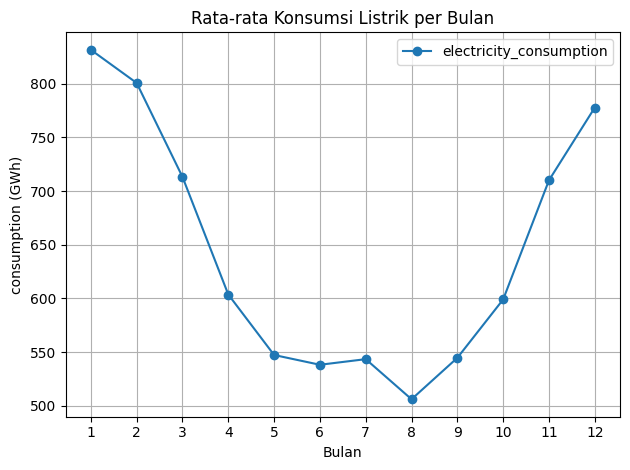

In [79]:
#chart untuk melihat rata rata konsumsi per bulan
monthly_avg = all_df.groupby('month')['electricity_consumption'].mean()
monthly_avg.plot(kind='line', marker='o', title='Rata-rata Konsumsi Listrik per Bulan')
plt.ylabel('consumption (GWh)')

plt.xlabel('Bulan')
plt.xticks(range(1, 13))
plt.grid(True)
plt.legend()
plt.tight_layout()
#ini bisa di artikan bahwa pemakaian listrik di bulan tertentu lebih tinggi, mungkin karena mpenggunaan heater atau ac



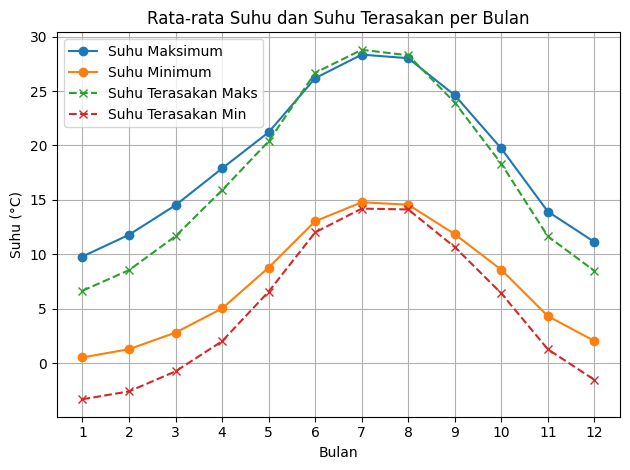

In [6]:

# 1. Hitung rata-rata per bulan
suhu_avg = all_df.groupby('month')[[
    'temperature_2m_max',
    'temperature_2m_min',
    'apparent_temperature_max',
    'apparent_temperature_min'
]].mean().reset_index()

# 2. Plot

plt.plot(suhu_avg['month'], suhu_avg['temperature_2m_max'], label='Suhu Maksimum', marker='o')
plt.plot(suhu_avg['month'], suhu_avg['temperature_2m_min'], label='Suhu Minimum', marker='o')
plt.plot(suhu_avg['month'], suhu_avg['apparent_temperature_max'], label='Suhu Terasakan Maks', linestyle='--', marker='x')
plt.plot(suhu_avg['month'], suhu_avg['apparent_temperature_min'], label='Suhu Terasakan Min', linestyle='--', marker='x')

plt.title('Rata-rata Suhu dan Suhu Terasakan per Bulan')
plt.xlabel('Bulan')
plt.ylabel('Suhu (°C)')
plt.xticks(range(1, 13))
plt.grid(True)
plt.legend()
plt.tight_layout()


#ini membuktikan bahwa penggunaan listrik yang besar di awal bulan dan akhir bulan karena penggunan heater, karena suhu yang rendah

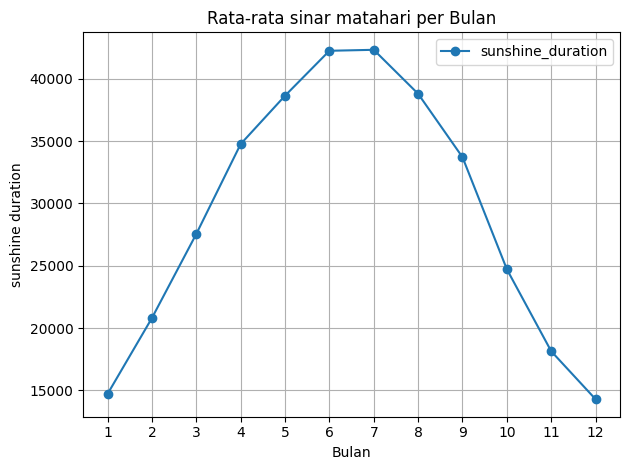

In [82]:
#chart untuk melihat rata rata matahari per bulan
sun_avg = all_df.groupby('month')['sunshine_duration'].mean()
sun_avg.plot(kind='line', marker='o', title='Rata-rata sinar matahari per Bulan')
plt.ylabel('sunshine duration')

plt.xlabel('Bulan')
plt.xticks(range(1, 13))
plt.grid(True)
plt.legend()
plt.tight_layout()
#fiks awal bulan akhir bulan adalah winter karena matahari yang sedikit

Text(0, 0.5, 'Konsumsi Listrik (GWh)')

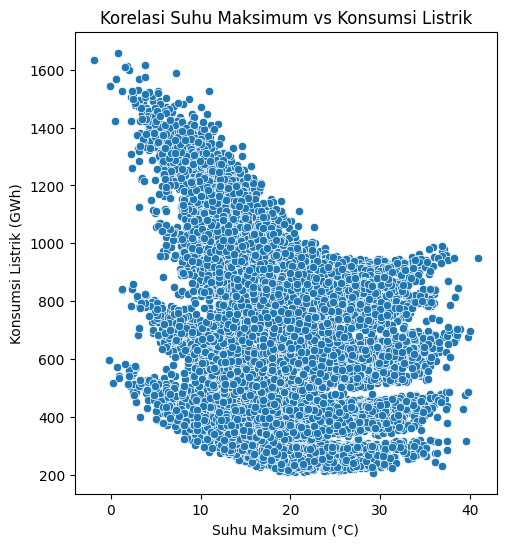

In [7]:


# 1. Buat figure kosong dengan 2 subplots
plt.figure(figsize=(12, 6))

# 2. Plot: Suhu Maksimum vs Konsumsi
plt.subplot(1, 2, 1)
sns.scatterplot(
    x=all_df['temperature_2m_max'],
    y=all_df['electricity_consumption']
)
plt.title('Korelasi Suhu Maksimum vs Konsumsi Listrik')
plt.xlabel('Suhu Maksimum (°C)')
plt.ylabel('Konsumsi Listrik (GWh)')



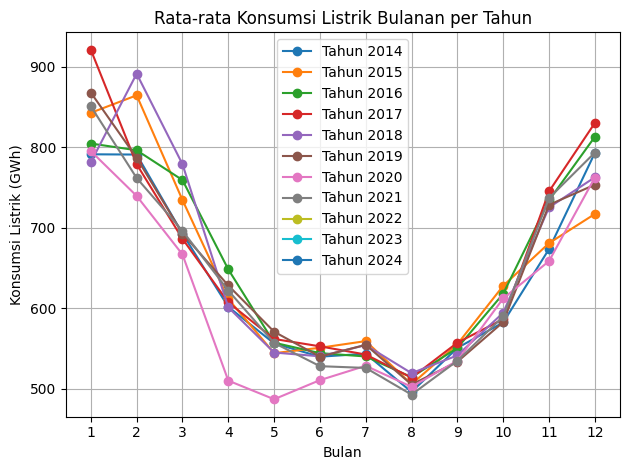

In [80]:
# Hitung rata-rata konsumsi listrik bulanan per tahun
monthly_avg_by_year = all_df.groupby(['year', 'month'])['electricity_consumption'].mean().reset_index()

# Plot per tahun
for year in monthly_avg_by_year['year'].unique():
    data = monthly_avg_by_year[monthly_avg_by_year['year'] == year]
    plt.plot(data['month'], data['electricity_consumption'], label=f'Tahun {year}', marker='o')

plt.title('Rata-rata Konsumsi Listrik Bulanan per Tahun')
plt.xlabel('Bulan')
plt.ylabel('Konsumsi Listrik (GWh)')
plt.xticks(range(1, 13))
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

#fiks   

In [ ]:
#no 5 a
# Hitung batas bawah (Q1) untuk suhu minimum
q1_temp_min = all_df['temperature_2m_min'].quantile(0.25)

# Hitung rata-rata durasi sinar matahari
mean_sunshine = all_df['sunshine_duration'].mean()

# Filter data sesuai kondisi
filtered_df = all_df[
    (all_df['temperature_2m_min'] < q1_temp_min) &
    (all_df['sunshine_duration'] < mean_sunshine)
]

# Hitung rata-rata konsumsi per cluster
cluster_avg = filtered_df.groupby('cluster_id')['electricity_consumption'].mean()
print(cluster_avg)

cluster_avg.plot(kind='bar', title='Rata-rata Konsumsi Listrik per Cluster (Suhu Min < Q1 dan Durasi Sinar Matahari < Rata-rata)')
plt.ylabel('Konsumsi Listrik (GWh)')


In [ ]:
# Hitung rata-rata konsumsi per cluster per bulan
monthly_cluster_avg = all_df.groupby(['cluster_id', 'month'])['electricity_consumption'].mean().reset_index()

# Urutkan untuk lihat nilai tertinggi & terendah
top_consumption = monthly_cluster_avg.sort_values(by='electricity_consumption', ascending=False).head(10)
low_consumption = monthly_cluster_avg.sort_values(by='electricity_consumption', ascending=True).head(10)

print("📈 Kombinasi Cluster + Bulan dengan Konsumsi Tertinggi:")
print(top_consumption)

print("\n📉 Kombinasi Cluster + Bulan dengan Konsumsi Terendah:")
print(low_consumption)

# Hitung rata-rata konsumsi per cluster per tahun
yearly_cluster_avg = all_df.groupby(['cluster_id', 'year'])['electricity_consumption'].mean().reset_index()

# Urutkan untuk melihat konsumsi tertinggi dan terendah
top_consumption = yearly_cluster_avg.sort_values(by='electricity_consumption', ascending=False).head(10)
low_consumption = yearly_cluster_avg.sort_values(by='electricity_consumption', ascending=True).head(10)

print("📈 Kombinasi Cluster + Tahun dengan Konsumsi Tertinggi:")
print(top_consumption)

print("\n📉 Kombinasi Cluster + Tahun dengan Konsumsi Terendah:")
print(low_consumption)

In [70]:
# SPLIT BACK DATA TRAIN DAN TEST
train_processed_df = all_df[all_df['is_test'] == 0].copy()
test_processed_df = all_df[all_df['is_test'] == 1].copy()

train_processed_df.drop(columns=['is_test'], inplace=True)
test_processed_df.drop(columns=['is_test'], inplace=True)

print(f"\nTrain processed shape: {train_processed_df.shape}")
print(f"Test processed shape: {test_processed_df.shape}")

for lag in lag_periods:
    col_name = f'consumption_lag_{lag}'
    mean_val = train_processed_df[col_name].mean()
    train_processed_df[col_name].fillna(mean_val, inplace=True)
    test_processed_df[col_name].fillna(mean_val, inplace=True)

print("\nMissing values di processed train data setelah lag imputation:")
print(train_processed_df.isnull().sum())
print("\nMissing values di processed test data setelah lag imputation (target should be NaN):")
print(test_processed_df.isnull().sum())

# Handle `cluster_id`
print("\n--- Handling Cluster ID ---")

le = LabelEncoder()
# Fit encoder on all unique cluster IDs from combined data to ensure consistency
all_cluster_ids = pd.concat([train_processed_df['cluster_id'], test_processed_df['cluster_id']]).unique()
le.fit(all_cluster_ids)

train_processed_df['cluster_id_encoded'] = le.transform(train_processed_df['cluster_id'])
test_processed_df['cluster_id_encoded'] = le.transform(test_processed_df['cluster_id'])

# Buang kolom 'cluster_id' asli (string), dan 'date' karena sudah diekstrak fiturnya
train_processed_df.drop(columns=['cluster_id', 'date'], inplace=True)
test_processed_df.drop(columns=['cluster_id', 'date'], inplace=True)

print("\nProcessed Train Data Head (after encoding and drop):")
print(train_processed_df.head())
print("\nProcessed Test Data Head (after encoding and drop):")
print(test_processed_df.head())




Train processed shape: (11688, 65)
Test processed shape: (3400, 65)

Missing values di processed train data setelah lag imputation:
date                       0
cluster_id                 0
electricity_consumption    0
temperature_2m_max         0
temperature_2m_min         0
                          ..
consumption_rollstd_7      0
consumption_rollmean_14    0
consumption_rollstd_14     0
consumption_rollmean_28    0
consumption_rollstd_28     0
Length: 65, dtype: int64

Missing values di processed test data setelah lag imputation (target should be NaN):
date                          0
cluster_id                    0
electricity_consumption    3400
temperature_2m_max            0
temperature_2m_min            0
                           ... 
consumption_rollstd_7         0
consumption_rollmean_14    3348
consumption_rollstd_14        0
consumption_rollmean_28    3292
consumption_rollstd_28        0
Length: 65, dtype: int64

--- Handling Cluster ID ---

Processed Train Data Head (aft

C:\Users\Lenovo\AppData\Local\Temp\ipykernel_19540\2222829889.py:14: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  train_processed_df[col_name].fillna(mean_val, inplace=True)
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_19540\2222829889.py:15: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a

In [ ]:
train_processed_df.head(10)

In [ ]:
cluster_avg = all_df.groupby('cluster_id')['electricity_consumption'].mean()
print(cluster_avg)

cluster_ids = cluster_avg.index.tolist()

print("Rasio Perbandingan Rata-rata Konsumsi Antar Cluster:\n")
for i in range(len(cluster_ids)):
    for j in range(i + 1, len(cluster_ids)):
        id_i = cluster_ids[i]
        id_j = cluster_ids[j]
        avg_i = cluster_avg[id_i]
        avg_j = cluster_avg[id_j]
        ratio = round(max(avg_i, avg_j) / min(avg_i, avg_j), 2)
        print(f"Cluster {id_i} vs Cluster {id_j}: rasio = {ratio}x")
        
pivot_df = all_df.pivot(index='date', columns='cluster_id', values='electricity_consumption')
correlation_matrix = pivot_df.corr()
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Korelasi Konsumsi Listrik Antar Cluster')
plt.show()

#menggunankan all_df karena sama saja
#hasil berarti data per cluster memiliki pola konsumsi yang mirip, sehingga cluster ini bisa di anggap sebagai satu kesatuan
# tidak perlu melakukan feature engineering per cluster, karena korelasi antar cluster cukup tinggi

In [ ]:

print(train_processed_df['cluster_id_encoded'].value_counts())
# berarti bukan karena banyak data

In [ ]:
cluster4_df = all_df[all_df['cluster_id'] == 'cluster_4']
cluster4_df['month'] = cluster4_df['date'].dt.month
monthly_avg = cluster4_df.groupby('month')['electricity_consumption'].mean()
monthly_avg.plot(title='Konsumsi Bulanan Cluster 4', marker='o')
plt.ylabel("consumption")
#berarti bukan karena cluster 4 memiliki pola konsumsi yang berbeda dari cluster lainnya

In [ ]:
cols = [
    'temperature_2m_max', 'temperature_2m_min',
    'apparent_temperature_max', 'apparent_temperature_min',
    'sunshine_duration', 'wind_speed_10m_max', 'shortwave_radiation_sum'
]

train_processed_df.groupby('cluster_id_encoded')[cols].mean().sort_values(by=3, axis=1)

#tinggi bukan karena perbedaan suhu atau cuaca

In [ ]:

# Bandingkan total konsumsi
all_df.groupby('cluster_id')['electricity_consumption'].sum()


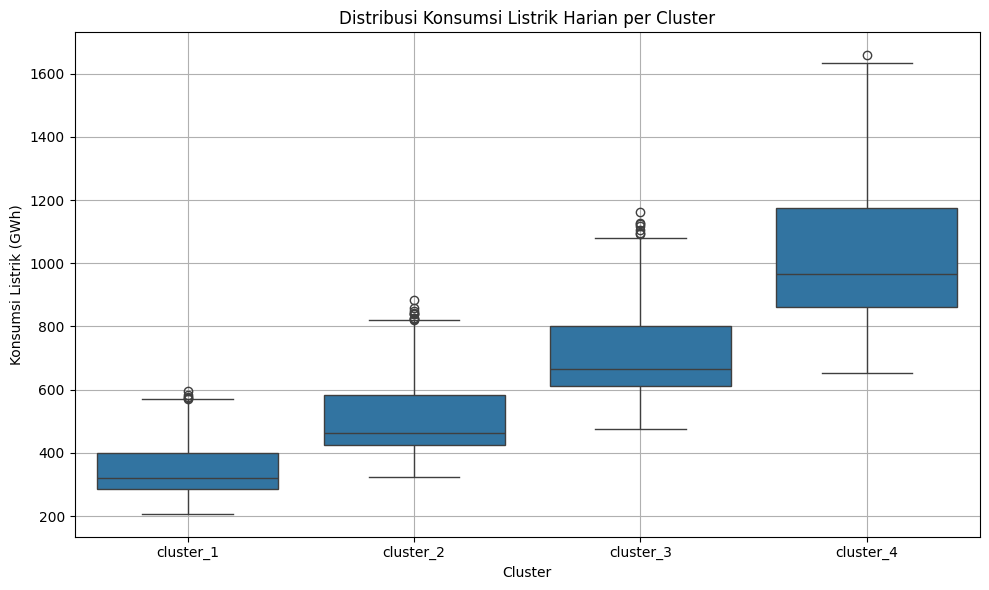

In [8]:
#last test
    
plt.figure(figsize=(10, 6))
sns.boxplot(x='cluster_id', y='electricity_consumption', data=all_df)

plt.title('Distribusi Konsumsi Listrik Harian per Cluster')
plt.xlabel('Cluster')
plt.ylabel('Konsumsi Listrik (GWh)')
plt.grid(True)
plt.tight_layout()
plt.show()



Training set size: 9350 rows
Validation set size: 2338 rows

--- Training LightGBM Model with Further Optimized Hyperparameters ---
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003768 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 13389
[LightGBM] [Info] Number of data points in the train set: 9350, number of used features: 63
[LightGBM] [Info] Start training from score 549.211065

Training complete.

RMSE on Validation Set (Further Optimized Model): 24.2577


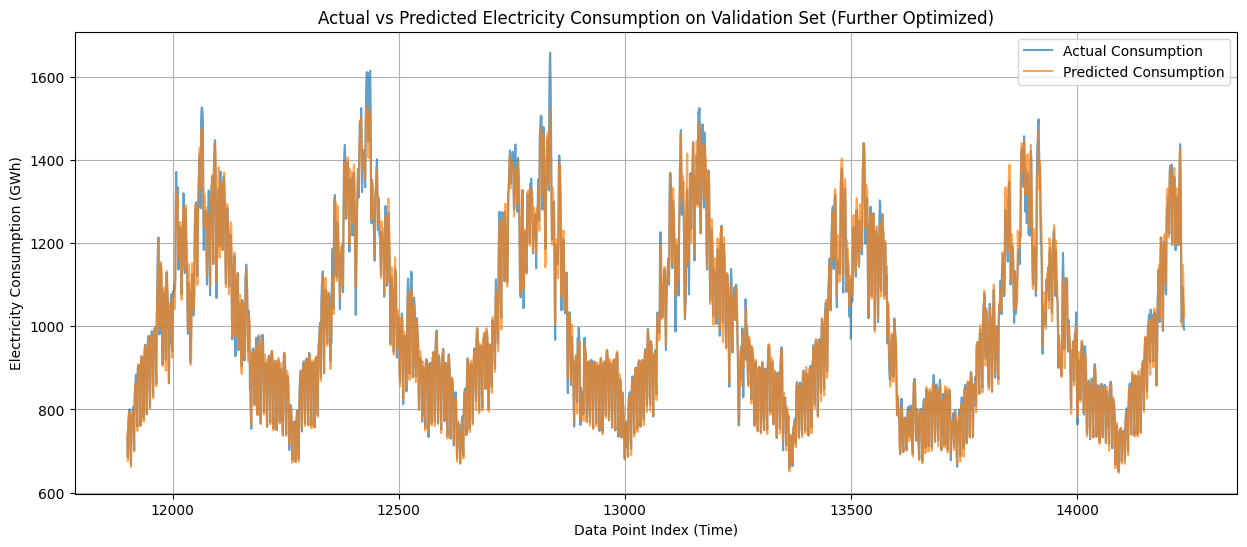

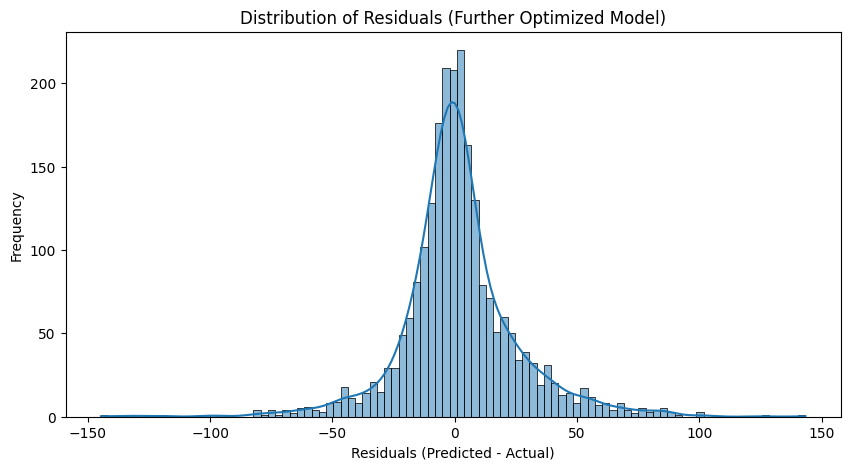

count    11688.000000
mean       642.313328
std        287.673473
min        207.472000
25%        414.376000
50%        602.672000
75%        836.034500
max       1658.348000
Name: electricity_consumption, dtype: float64


In [72]:
# MODEL TRAINING (LIGHTGBM) & VALIDASI BERBASIS WAKTU ---

# Petakan features (X) dan target (y)
target_col = 'electricity_consumption'
features = [col for col in train_processed_df.columns if col != target_col]

X = train_processed_df[features]
y = train_processed_df[target_col]

# 4.1 Time-Series Validation Split
split_point = int(len(train_processed_df) * 0.8)

X_train, X_val = X.iloc[:split_point], X.iloc[split_point:]
y_train, y_val = y.iloc[:split_point], y.iloc[split_point:]

print(f"\nTraining set size: {len(X_train)} rows")
print(f"Validation set size: {len(X_val)} rows")

# Inisialisasi model LightGBM dengan parameter yang LEBIH dioptimalkan
lgbm_model = lgb.LGBMRegressor(
    objective='regression',    # Tetap, optimalkan untuk MSE
    metric='rmse',             # Metrik evaluasi selama training
    n_estimators=10000,        # BERUBAH: Jauh lebih banyak pohon
    learning_rate=0.005,       # BERUBAH: Learning rate lebih kecil
    num_leaves=95,             # BERUBAH: Jumlah daun per pohon yang sedikit lebih tinggi
    max_depth=-1,              # Default, tidak ada batasan kedalaman
    min_child_samples=20,      # Default, jumlah sampel minimum di daun
    subsample=0.8,             # Tambahan: Bagging fraction, menggunakan 80% data untuk setiap pohon
    colsample_bytree=0.8,      # Tambahan: Feature fraction, menggunakan 80% fitur untuk setiap pohon
    reg_alpha=0.1,             # Tambahan: L1 regularization (Lasso)
    reg_lambda=0.1,            # Tambahan: L2 regularization (Ridge)
    random_state=42,           # Untuk hasil yang reproducible
    n_jobs=-1,                 # Menggunakan semua core CPU yang tersedia
)

print("\n--- Training LightGBM Model with Further Optimized Hyperparameters ---")
lgbm_model.fit(X_train, y_train,
                eval_set=[(X_val, y_val)],
                eval_metric='rmse',
                callbacks=[lgb.early_stopping(150, verbose=False)])

print("\nTraining complete.")

# 4.2 Evaluasi Model on Validation Set
predictions_val = lgbm_model.predict(X_val)
rmse_val = np.sqrt(mean_squared_error(y_val, predictions_val))
print(f"\nRMSE on Validation Set (Further Optimized Model): {rmse_val:.4f}")

# Visualisasi prediksi vs aktual
plt.figure(figsize=(15, 6))
plt.plot(y_val.index, y_val, label='Actual Consumption', alpha=0.7)
plt.plot(y_val.index, predictions_val, label='Predicted Consumption', alpha=0.7)
plt.title('Actual vs Predicted Electricity Consumption on Validation Set (Further Optimized)')
plt.xlabel('Data Point Index (Time)')
plt.ylabel('Electricity Consumption (GWh)')
plt.legend()
plt.grid(True)
plt.show()

# Visualisasi Residuals (Prediksi - Aktual)
residuals = predictions_val - y_val
plt.figure(figsize=(10, 5))
sns.histplot(residuals, kde=True)
plt.title('Distribution of Residuals (Further Optimized Model)')
plt.xlabel('Residuals (Predicted - Actual)')
plt.ylabel('Frequency')
plt.show()


print(train_df['electricity_consumption'].describe())

In [75]:
print(f"RMSE Training:   {rmse_train:.4f}")
print(f"RMSE Validation: {rmse_val:.4f}")


RMSE Training:   0.5327
RMSE Validation: 24.2577


In [9]:
plt.figure(figsize=(15, 6))
plt.plot(y_val.index, y_val, label='Actual')
plt.plot(y_val.index, pred_val, label='Predicted')
plt.legend()
plt.title("Actual vs Predicted on Validation Set")
plt.show()


NameError: name 'y_val' is not defined

<Figure size 1500x600 with 0 Axes>

In [ ]:
# MODELLING DAN PREDIKSI TEST DATA ---  

# Prediksi di Test Data ---
print("\n--- Predicting on Test Data ---")
test_predictions = lgbm_model.predict(test_processed_df[features])

# Pastikan prediksi tidak negatif (konsumsi listrik tidak mungkin negatif)
test_predictions[test_predictions < 0] = 0

# --- Membuat Submission File Sementara ---
submission_df = pd.DataFrame({'ID': test_ids, 'electricity_consumption': test_predictions})

test_original_df = pd.read_csv('test.csv') # Load ulang test.csv untuk akses ID aslinya
test_original_df['date'] = pd.to_datetime(test_original_df['date'])
test_original_df['formatted_id'] = test_original_df['cluster_id'].astype(str) + '_' + test_original_df['date'].dt.strftime('%Y-%m-%d')

submission_df = pd.DataFrame({
    'ID': test_original_df['formatted_id'],
    'electricity_consumption': test_predictions
})


# Menyimpan submission file di submission.csv
submission_df.to_csv('submission.csv', index=False)